# Predicting User decision using Models

In [1]:
# Load Library
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import sklearn
import libsvm
from libsvm.svmutil import *
import pandas as pd
import seaborn as sns


%matplotlib inline

In [2]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  

## 1 Exploratory Analysis

In [3]:
# Read in Samples 
decision = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")
test = pd.concat((test, decision['Decision']), axis = 1,sort=False)
train = pd.read_csv("train.csv")
test['data'] = 'test'
train['data'] = 'train'
# Combine Test and Train Data for EDA 
Combined = pd.concat((test, train), axis = 0, ignore_index = True,sort=False)
print(Combined.shape)

(9911, 23)


There are 2440 test data with 23 variables. There are 7471 data with 23 variables. We have features include
* id                        
* Host_response_time       
* Host_is_superhost         
* Host_has_profile_pic      
* Host_identity_verified    
* Neighbourhood             
* Property_type             
* Room_type                 
* Accommodates              
* Bathrooms_text           
* Bedrooms                  
* Beds                     
* Essentials           
* Cooking                 
* Balcony                  
* Parking                 
* Price                     
* Number_of_reviews         
* Review_scores_rating      
* Instant_bookable          
* Month       

## Predictive Variables 
We want to predictive the decision of user which is a binary variable: 1 represents booked; 0 represents did not book. Among 9911 dataset (including both test and trained data), there are 5176 did not book while 4735 booked. 

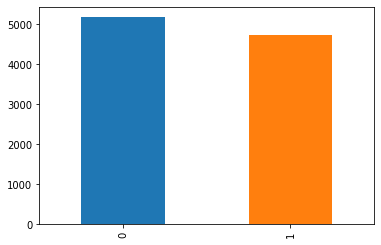

In [4]:
Combined['Decision'].value_counts()
Combined.Decision.value_counts(dropna=False).plot(kind='bar', color=colors)

In [5]:
# We first drop variables  
Combined = Combined.drop(['id'], axis=1) # we want to drop id 

##  Explanatory Variables 
### Binary Variables
* Host_is_superhost
* Host_has_profile_pic
* Host_identity_verified
* Instant_bookable 
Variables listed above will be turned into a binary variable: true is represented as 1, false is represented as 0. 

In [6]:
# Most Host has profile picture, we drop such variable. 
Combined['Host_has_profile_pic'].value_counts()
Combined = Combined.drop(['Host_has_profile_pic'], axis=1) 

In [7]:
Combined['Host_is_superhost'] = Combined['Host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
Combined['Host_identity_verified'] = Combined['Host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
Combined['Instant_bookable'] = Combined['Instant_bookable'].apply(lambda x: 1 if x == 't' else 0)

### Categorical Variable  
* Neighbourhood
* Property_type
* Room_type
* Month
* Bathrooms_text
We use one-hot-encoding to on categorical variables. 

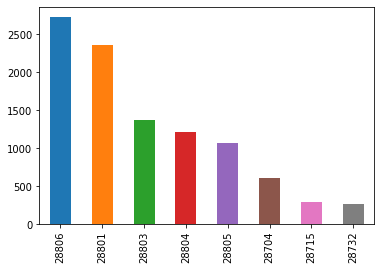

In [8]:
# Neighbourhood
Combined['Neighbourhood'].value_counts()
Combined.Neighbourhood.value_counts(dropna=False).plot(kind='bar', color=colors)
Combined = Combined.drop(['Neighbourhood'], axis=1) 

In [9]:
# Property_type 
## We will drop property type because of its high dimensionality 
Combined['Property_type'].value_counts()
Combined = Combined.drop(['Property_type'], axis=1) 

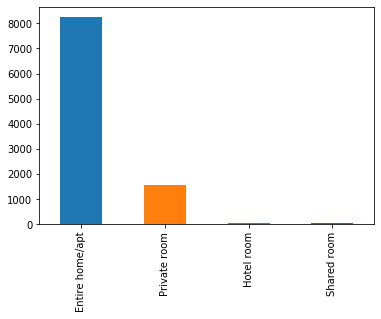

In [10]:
# Room_type
# Combined['Host_response_time'].value_counts()
Combined['Room_type'].value_counts()
Combined.Room_type.value_counts(dropna=False).plot(kind='bar', color=colors)

<Figure size 1080x432 with 0 Axes>

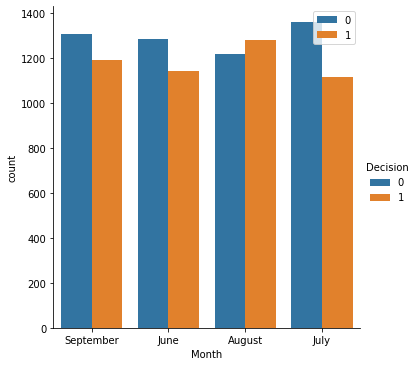

In [11]:
# Month
Combined['Month'].value_counts()

# Plot Price vs Room_type vs Month
plt.figure(figsize=(15, 6))
sns.catplot(x='Month',hue='Decision',data=Combined,kind="count")

# plt.ylim(15, 60)
plt.legend(loc='upper right')
plt.show()

In [12]:
# Bathrooms_text
## We will drop Bathrooms_text because of its high dimensionality 
Combined['Bathrooms_text'].value_counts()
Combined = Combined.drop(['Bathrooms_text'], axis=1) 

#### Numeric Data
We have Numeric data including 
* Bedrooms
* Beds
* Accommodates
* Parking
* Balcony
* Review_scores_rating
* Price
* Number_of_reviews. 

In [13]:
# Turn Price into int
Combined['Price'] = Combined['Price'].str.replace('$','')
Combined['Price'] = Combined['Price'].str.replace(',','')
Combined['Price'] = pd.to_numeric(Combined['Price'], errors='coerce')

In [14]:
Combined[["Bedrooms", "Beds","Accommodates","Parking","Balcony","Review_scores_rating","Price","Number_of_reviews"]].describe()

,Bedrooms,Beds,Accommodates,Parking,Balcony,Review_scores_rating,Price,Number_of_reviews
count,9177.000000,9889.000000,9911.000000,9911.000000,9911.000000,9242.000000,9911.000000,9911.000000
mean,1.840253,2.294570,4.303400,0.956513,0.630915,4.878196,183.823429,83.068106
std,1.107743,1.753087,2.743834,0.203961,0.482581,0.248713,172.896869,106.744149
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,19.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,0.000000,4.850000,92.000000,11.000000
50%,1.000000,2.000000,4.000000,1.000000,1.000000,4.930000,135.000000,46.000000
75%,2.000000,3.000000,6.000000,1.000000,1.000000,4.990000,221.500000,114.000000
max,9.000000,21.000000,16.000000,1.000000,1.000000,5.000000,3500.000000,1059.000000


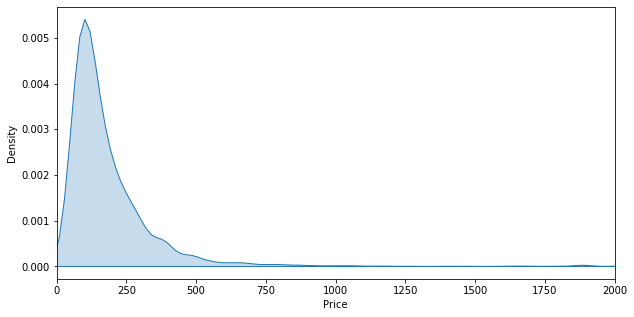

In [15]:
plt.figure(figsize=(10,5))
plt.xlim(0,2000)
plt.xlabel('Price')
plt.ylabel('Density')
sns.kdeplot(Combined['Price'],shade=True)
plt.show()

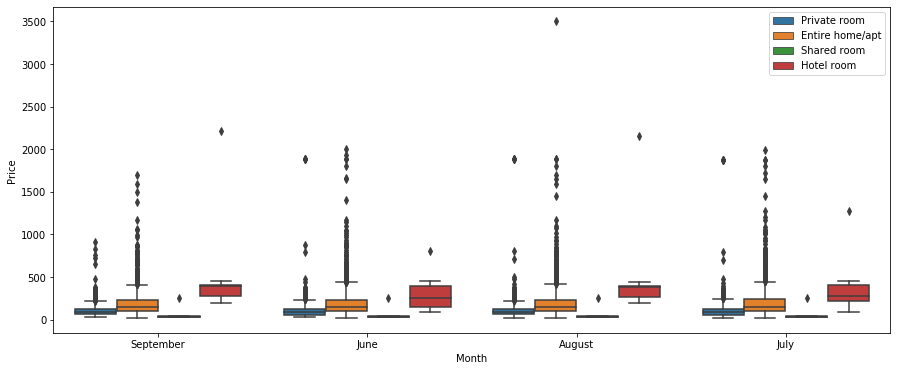

In [16]:
# Plot Price vs Room_type vs Month
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='Price', hue = 'Room_type', data=Combined)
# plt.ylim(15, 60)
plt.legend(loc='upper right')
plt.show()

Hotel room on averag has a higher price compared to other room type. August are more expensive on average compared to other month. Entire home/apartment has larger spread.  

/Users/yuchenlu/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


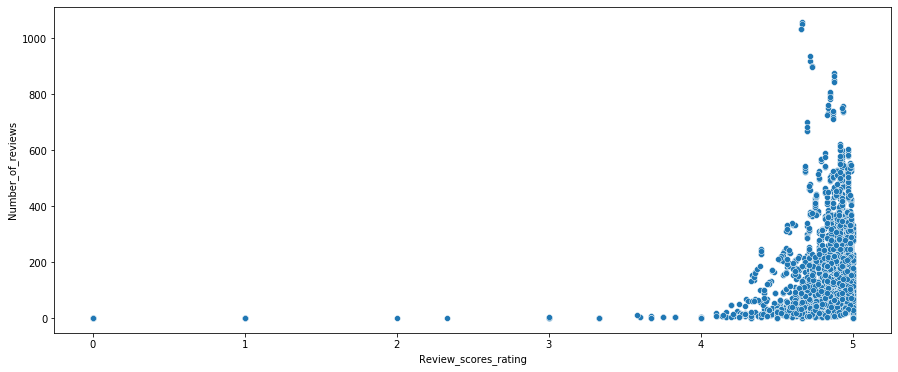

In [17]:
# Review_scores_rating vs Number_of_reviews
# Combined["Review_scores_rating"].value_counts()
plt.figure(figsize=(15, 6))
sns.scatterplot(Combined['Review_scores_rating'],Combined["Number_of_reviews"])
plt.show()

## Data Processing 
### Remove NA

In [18]:
# Combined.isnull().sum()
Combined_new = Combined.dropna(axis = 0, how ='any')

### Selecting Model 

In [22]:
Combined_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7674 entries, 1 to 9910
Data columns (total 18 columns):
Host_response_time        7674 non-null object
Host_is_superhost         7674 non-null int64
Host_identity_verified    7674 non-null int64
Room_type                 7674 non-null object
Accommodates              7674 non-null int64
Bedrooms                  7674 non-null float64
Beds                      7674 non-null float64
Essentials                7674 non-null int64
Cooking                   7674 non-null int64
Balcony                   7674 non-null int64
Parking                   7674 non-null int64
Price                     7674 non-null float64
Number_of_reviews         7674 non-null int64
Review_scores_rating      7674 non-null float64
Instant_bookable          7674 non-null int64
Month                     7674 non-null object
Decision                  7674 non-null int64
data                      7674 non-null object
dtypes: float64(4), int64(10), object(4)
memory usage

### Dummy Variables 

In [23]:
# Get dummy variables for Neighbourhood; Room_type;Month, Property_type.
features = ['Room_type', 'Month','Host_response_time']
Combined_new = pd.get_dummies(Combined_new,columns=features)

## Prep Test/Train Data

In [24]:
# Split test data
test = Combined_new[Combined_new["data"] == "test"]
test_x = test.drop(['Decision','data'], axis=1) 
test_y = test['Decision']
# Split train data
train = Combined_new[Combined_new["data"] == "train"]
train_x = train.drop(['Decision','data'], axis=1) 
train_y = train['Decision']

In [25]:
# Split 20% as test data and 80% as train data
from sklearn.model_selection import train_test_split
X = train_x 
Y = train_y
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

# Model
## Logistic Regression with Step-wise Feature Selection

In [60]:
import statsmodels.api as sm
x_columns =  list(X_train.columns)
y = y_train
def get_stats():
    x = X_train[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [61]:
get_stats()

                            OLS Regression Results                            
Dep. Variable:               Decision   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     23.61
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.61e-90
Time:                        21:32:35   Log-Likelihood:                -2836.9
No. Observations:                4692   AIC:                             5720.
Df Residuals:                    4669   BIC:                             5868.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [62]:
x_columns.remove("Balcony")
get_stats()

                            OLS Regression Results                            
Dep. Variable:               Decision   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     24.74
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.20e-91
Time:                        21:32:35   Log-Likelihood:                -2836.9
No. Observations:                4692   AIC:                             5718.
Df Residuals:                    4670   BIC:                             5860.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [63]:
x_columns.remove("Beds")
get_stats()

                            OLS Regression Results                            
Dep. Variable:               Decision   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     25.98
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.45e-92
Time:                        21:32:36   Log-Likelihood:                -2836.9
No. Observations:                4692   AIC:                             5716.
Df Residuals:                    4671   BIC:                             5851.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [66]:
x_columns.remove("Review_scores_rating")
get_stats()

                            OLS Regression Results                            
Dep. Variable:               Decision   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     27.35
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.23e-92
Time:                        21:33:14   Log-Likelihood:                -2837.0
No. Observations:                4692   AIC:                             5714.
Df Residuals:                    4672   BIC:                             5843.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [72]:
x_columns.remove("Bedrooms") 
x_columns.remove("Cooking") 
x_columns.remove("Price") 
x_columns.remove("Host_is_superhost") 
x_columns.remove("Host_response_time_within a day")
x_columns.remove("Host_response_time_a few days or more")
get_stats()

                            OLS Regression Results                            
Dep. Variable:               Decision   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     36.07
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.52e-93
Time:                        21:35:23   Log-Likelihood:                -2843.8
No. Observations:                4692   AIC:                             5718.
Df Residuals:                    4677   BIC:                             5814.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [89]:
# Remaining Variables 
X_train = X_train[x_columns]
X_test = X_test[x_columns]
X_test.head()

,Host_identity_verified,Accommodates,Essentials,Parking,Number_of_reviews,Instant_bookable,Room_type_Entire home/apt,Room_type_Hotel room,Room_type_Private room,Room_type_Shared room,Month_August,Month_July,Month_June,Month_September,Host_response_time_within a few hours,Host_response_time_within an hour
7740,0,2,2,1,59,1,0,0,1,0,0,0,0,1,0,1
4418,1,2,5,1,6,0,1,0,0,0,0,0,1,0,0,1
4870,1,5,5,1,97,0,1,0,0,0,0,0,0,1,0,1
2668,0,7,5,1,158,1,1,0,0,0,0,1,0,0,0,1
3204,0,2,5,1,69,0,1,0,0,0,0,0,1,0,0,1


## Logistic Regression Base Model

/Users/yuchenlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


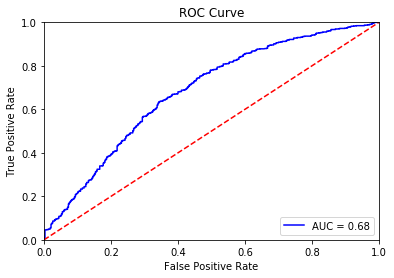

the accuracy score is 0.702725724020443


In [86]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from scipy.stats import sem
from numpy import mean
from numpy import std
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]
# define model
model = LogisticRegression()
# fit a model
model = LogisticRegression() #penalty = 'l2', solver='liblinear',
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

Evaluates a logistic regression model on it using 10-fold cross-validation. The model achieved an accuracy score of about 0.702725724020443.

### Evaluation: KFold Cross Validation

>1 mean=0.7023 se=0.007
>2 mean=0.7018 se=0.004
>3 mean=0.7013 se=0.003
>4 mean=0.7009 se=0.003
>5 mean=0.7011 se=0.003
>6 mean=0.7009 se=0.003
>7 mean=0.7010 se=0.002
>8 mean=0.7013 se=0.002
>9 mean=0.7011 se=0.002
>10 mean=0.7012 se=0.002
>11 mean=0.7012 se=0.002
>12 mean=0.7012 se=0.002
>13 mean=0.7012 se=0.002
>14 mean=0.7012 se=0.002
>15 mean=0.7015 se=0.002


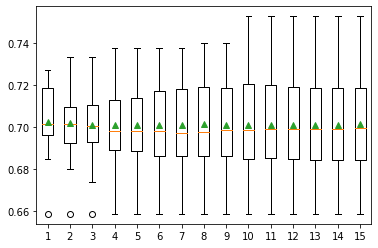

In [82]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # create model
    model = LogisticRegression()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# configurations to test
repeats = range(1,16)
results = list()
for r in repeats:
    # evaluate using a given number of repeats
    scores = evaluate_model(X_train, y_train, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    # store
    results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()

We can see that the mean seems to coalesce around a value of about 70.5 percent. We might take this as the stable estimate of model performance and in turn, choose 4 or 5 repeats that seem to approximate this value first. Looking at the standard error, we can see that it decreases with an increase in the number of repeats and stabilizes with a value around 0.002 at around 7 or 8 repeats, although 5 repeats achieve a standard error of 0.003. 

## Optimize Logistic Regression 
### With Grid Search

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

# Hyperparameter Space
## solver space 
solver = ['liblinear']
## Penalty space
penalty = ['l1', 'l2']
## Regularization hyperparameter space
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty,solver = solver)

# Create grid search using 5-fold cross validation 
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
# Fit grid search
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


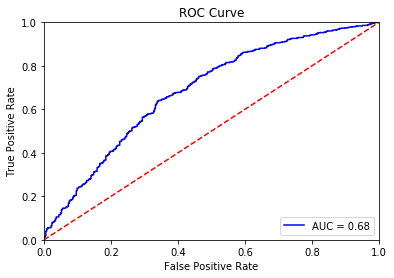

the accuracy score is 0.7035775127768313


In [90]:
model = LogisticRegression(penalty='l2',solver='liblinear', C = 1.0 ,max_iter=1000)
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

In [42]:
prediction = model.predict(test_x)

In [43]:
# np.savetxt("submission.csv", prediction, delimiter=",")
pd.DataFrame(prediction).to_csv("prediction.csv")

After tunning the hyperparameter, we see increase in acucracy score from 0.701 to 0.7035775127768313. 

## Random Forest
### Base Model 

In [101]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-0.36431150770584914

# Optimization using GridsearchCV 

In [102]:
num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt']
rf_parameters = [{'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X_train,y_train)

rf_gs.best_score_ # -56.048108459722435
rf_gs.best_estimator_

RandomForestRegressor(max_depth=9, min_samples_leaf=5, n_estimators=1)

In [103]:
rf = RandomForestRegressor(max_depth=9, n_estimators=7)
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-0.3787395706616525

# Decision Tree 
## Base Model

In [97]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf=.01)
dtr.fit(X_train,y_train)
np.mean(cross_val_score(dtr,X_train,y_train, scoring = 'neg_mean_absolute_error', cv = 3)) # NMAE = -58.64131895872581

-0.38562351517520904

In [104]:
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
dt_parameters = [{'max_depth' : depths,
                  'min_samples_leaf' : num_leafs}]

dt_gs = GridSearchCV(DecisionTreeRegressor(), dt_parameters, scoring = 'neg_mean_absolute_error',cv = 3)
dt_gs.fit(X_train,y_train)

dt_gs.best_score_ 
dt_gs.best_estimator_

DecisionTreeRegressor(max_depth=9, min_samples_leaf=3)

## Support vector machines

In [ ]:
# pip install xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder